In [23]:
import numpy as np
import random
import math
import matplotlib as plt
import matplotlib.pyplot as pyplt
import pickle

# Helper functions

In [24]:
def random_init(l,f):
    filt=np.random.randn(l,f,f)
    bias=np.random.randn(l,f,f)
    return filt,bias

In [25]:
def random_init2(rows,cols):
    weight=np.random.randn(rows,cols)
    bias=np.random.randn(1,cols)
    return weight,bias

In [26]:
def flatten(x):
    return x.flatten()

In [27]:
def extract_data(data_file,label_file):
    with open(data_file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    #dict has batchno,labels,filenames,data
    X=np.reshape(data_dict[b'data'],(10000,3,1024))
    Y=np.array(data_dict[b'labels'])
    
    with open(label_file, 'rb') as fo:
        label_dict = pickle.load(fo, encoding='bytes')
    labels=label_dict[b'label_names']
    
    return X,Y,labels


###Testing
# data_file="./cifar-10-python/cifar-10-batches-py/data_batch_1"
# label_file="./cifar-10-python/cifar-10-batches-py/batches.meta"
# X,Y,labels=extract_data(data_file,label_file)
# print(X.shape)
# print(Y.shape)
# print(X[0].shape)
# print(labels)
##########
# print(len(dict[b'labels']))
# print(dict[b'data'].shape)
# print(dict[b'data'][0])
# X=np.reshape(dict[b'data'],(10000,3,1024))
# print(X.shape)
# print(X[0])

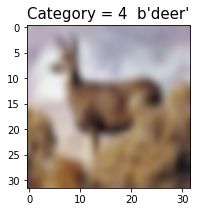

In [28]:
def plot_CIFAR(X,ind,Y,labels):
    arr = X[ind]
    R = arr[0].reshape(32,32)/255.0
    G = arr[1].reshape(32,32)/255.0
    B = arr[2].reshape(32,32)/255.0
 
    img = np.dstack((R,G,B))
    title = str(str(Y[ind])+"  "+str(labels[Y[ind]]))
    fig = pyplt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)
    ax.imshow(img,interpolation='bicubic')
    ax.set_title('Category = '+ title,fontsize =15)

data_file="./cifar-10-python/cifar-10-batches-py/data_batch_1"
label_file="./cifar-10-python/cifar-10-batches-py/batches.meta"
X,Y,labels=extract_data(data_file,label_file)
rando = random.randint(0,len(Y)-1)
plot_CIFAR(X,rando,Y,labels)

In [29]:
def plot_img(img,ind,Y,labels,img_title):
    #print(img.shape)
    l,d,d=img.shape
    arr = img
#     l_list=[]
#     for i in range(l):
#         l_list.append(arr[i])
    R = arr[0]/255.0
    R = R.astype(float)
    G = arr[1]/255.0
    G = G.astype(float)
    B = arr[2]/255.0
    B = B.astype(float)
 
    img = np.dstack((R,G,B))
    title = str(str(Y[ind])+"  "+str(labels[Y[ind]]))
    fig = pyplt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)
    ax.imshow(img,interpolation='bicubic')
    ax.set_title(img_title+'Category = '+ title,fontsize =15)
    
# data_file="./cifar-10-python/cifar-10-batches-py/data_batch_1"
# label_file="./cifar-10-python/cifar-10-batches-py/batches.meta"
# X,Y,labels=extract_data(data_file,label_file)
# plot_img(X,1,Y,labels,"testing")

In [30]:
def one_hot_encode(Y,no_labels):
    encoded_Y=np.zeros((len(Y),no_labels))
    for i in range(0,len(Y)):
        encoded_Y[i,Y[i]]=1
    return encoded_Y

# CNN Functions

In [31]:
def reLU(x):
    z = np.zeros_like(x)
    return np.where(x>z,x,z)

In [32]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    s = e_x / e_x.sum()
    return s

In [33]:
def sigmoid(X):
    sigmoid_ans=np.zeros(X.shape,dtype=np.float128)
    for i in range(0,len(X)):
        x=X[i]
        exp_part=np.exp(-x)
        sigmoid_ans[i]=1/(1+exp_part)
    #print("sigmoid_ans-",sigmoid_ans)
    return sigmoid_ans

In [34]:
def tanh(X):
    tanh_ans=np.zeros(X.shape,dtype=np.float128)
    for i in range(0,len(X)):
        x=X[i]
        exp_part=np.exp(-2*x)
        tanh_ans[i]=(2/(1+exp_part))-1
    #print("tanh_ans-",tanh_ans)
    return tanh_ans

In [35]:
def convolve(img,filt,bias):
    #img - c*d*d
    #filt - l*f*f
    #bias - l*
    #output - l*(d-f+1)*(d-f+1)
    (c, d, d) = img.shape
    l = len(filt)
    (f, f) = filt[0].shape
    conv_dim=d-f+1
    #print("conv dims - ",conv_dim )
    
    conv = np.zeros((l,conv_dim,conv_dim))
    for i in range(0,l):
        for x in range(0,conv_dim):
            for y in range(0,conv_dim):
                conv[i,x,y] = np.sum((img[:,x:x+f,y:y+f]*filt[i])+bias[i])
    return conv

In [36]:
# #convolve testing
# # c = 3
# img=np.array([[[3,3,2,1,0],
#               [0,0,1,3,1],
#               [3,1,2,2,3],
#               [2,0,0,2,2],
#               [2,0,0,0,1]],
#               [[3,3,2,1,0],
#               [0,0,1,3,1],
#               [3,1,2,2,3],
#               [2,0,0,2,2],
#               [2,0,0,0,1]],
#               [[3,3,2,1,0],
#               [0,0,1,3,1],
#               [3,1,2,2,3],
#               [2,0,0,2,2],
#               [2,0,0,0,1]]])
# filt=np.array([[[0,1,2],
#                [2,2,0],
#                [0,1,2]],
#                [[0,1,2],
#                [2,2,0],
#                [0,1,2]],
#                [[0,1,2],
#                [2,2,0],
#                [0,1,2]]])
# bias=np.array([[[0,0,0],
#                [0,0,0],
#                [0,0,0]],
#                [[0,0,0],
#                [0,0,0],
#                [0,0,0]],
#                [[0,0,0],
#                [0,0,0],
#                [0,0,0]]])


# (c, d, d) = img.shape
# l = len(filt)
# (f, f) = filt[0].shape
# conv_dim=d-f+1
# print(conv_dim)

# #Part of array
# #print(img[:,2:2+f,2:2+f])

# conv = np.zeros((l,conv_dim,conv_dim))
# for i in range(0,l):
#     for x in range(0,conv_dim):
#         for y in range(0,conv_dim):
#             #conv[i,x,y] = np.sum(img[:,x:x+f,y:y+f]*filt[i])+bias[i]
# #             print("x,y ",x,y)
# #             temp=img[i,x:x+f,y:y+f]
# #             print(temp)
# #             print(filt[i])
# #             print("img shape ",temp.shape)
# #             print("filt shape ",filt[i].shape)
# #             temp2=(temp*filt[i])+bias[i]
# #             print(temp2)
# #             val=np.sum(temp2)
# #             print("****Val is ",val)
#             conv[i,x,y] = np.sum((img[i,x:x+f,y:y+f]*filt[i])+bias[i])
                
# print(conv)

In [37]:
def max_pool(img,p,s):
    (c, d, d) = img.shape
    pool_size=int(d/p)    #(w-f)/s+1,(w-f)/s+1))??
    pool = np.zeros((c, pool_size , pool_size)) 
    for i in range(0,c):
        j=0
        while(j<d):
            k=0
            while(k<d):
                ind_j=int(j/p)
                ind_k=int(k/p)
                pool[i,ind_j,ind_k] = np.max(img[i,j:j+p,k:k+p])
                k+=s
            j+=s
    return pool

In [38]:
# ##pool test
# img=np.array([[[1,1,2,4],
#               [5,6,7,8],
#               [3,2,1,0],
#               [1,2,3,4]],
#               [[1,1,2,4],
#               [5,6,7,8],
#               [3,2,1,0],
#               [1,2,3,4]],
#               [[1,1,2,4],
#               [5,6,7,8],
#               [3,2,1,0],
#               [1,2,3,4]]])
# pool=max_pool(img,2,2)
# print(pool)

In [39]:
def FC_convolution(img,weight,bias):
    return img.dot(weight)+bias

In [40]:
def FC_layer(img,weight,bias):
    return img.dot(weight)+bias

In [41]:
def CNN_sigmoid(img,ind,params,Y,labels):
    
    filt1,bias1,filt2,bias2,fc_w1,fc_b1,fc_w2,fc_b2,fc_w3,fc_b3 = params
    
    #Reshape image
    c,dims=img.shape
    d=int(math.sqrt(dims))
    new_img=np.zeros((c,d,d))
    for i in range(c):
        new_img[i]=img[i].reshape(d,d)  ##Check
        
    #variables
    p=2
    s=2
        
    #C1:CONV 1
    conv1=convolve(new_img,filt1,bias1)
    print("After CONV 1 ")
    print(conv1.shape)
    plot_img(conv1,ind,Y,labels,"Sigmoid After CONV 1  ")
    
    #sigmoid
    conv1=sigmoid(conv1)
    print("After sigmoid 1-")
    plot_img(conv1,ind,Y,labels,"Sigmoid After sigmoid 1  ")
    
    #S2:POOL 1
    pool1=max_pool(conv1,p,s)
    print("After pool1 -")
    print(pool1.shape)
    plot_img(pool1,ind,Y,labels,"Sigmoid After POOL 1  ")
    
    #C3:CONV 2
    conv2=convolve(pool1,filt2,bias2)
    print("After CONV 2 ")
    print(conv2.shape)
    plot_img(conv2,ind,Y,labels,"Sigmoid After CONV 2  ")
    
    #sigmoid
    conv2=sigmoid(conv2)
    print("After sigmoid 2-")
    print(conv2.shape)
    plot_img(conv2,ind,Y,labels,"Sigmoid After sigmoid 2  ")
    
    #S4:POOL 2
    pool2=max_pool(conv2,p,s)
    print("After pool2 -")
    print(pool2.shape)
    plot_img(pool2,ind,Y,labels,"Sigmoid After POOL 2  ")
    
    #Flatten
    flat_img=flatten(pool2)
    print(flat_img.shape)
    
    #C5:fully connected convolution
    conv5=FC_convolution(flat_img,fc_w1,fc_b1)
    print(conv5.shape)
    
    #F6:fully connected
    fc=FC_layer(conv5,fc_w2,fc_b2)
    print(fc.shape)
    
    #Ouput
    fc=FC_layer(fc,fc_w3,fc_b3)
    print(fc)
    output=softmax(fc)
    print(output.shape)
    print(np.round(output))
    
    return

In [42]:
def CNN_tanh(img,ind,params,Y,labels):
    
    filt1,bias1,filt2,bias2,fc_w1,fc_b1,fc_w2,fc_b2,fc_w3,fc_b3 = params
    
    #Reshape image
    c,dims=img.shape
    d=int(math.sqrt(dims))
    new_img=np.zeros((c,d,d))
    for i in range(c):
        new_img[i]=img[i].reshape(d,d)  ##Check
        
    #variables
    p=2
    s=2
        
    #C1:CONV 1
    conv1=convolve(new_img,filt1,bias1)
    print("After CONV 1 ")
    print(conv1.shape)
    plot_img(conv1,ind,Y,labels,"tanh After CONV 1  ")
    
    #tanh
    conv1=tanh(conv1)
    print("After tanh 1-")
    plot_img(conv1,ind,Y,labels,"tanh After tanh 1  ")
    
    #S2:POOL 1
    pool1=max_pool(conv1,p,s)
    print("After pool1 -")
    print(pool1.shape)
    plot_img(pool1,ind,Y,labels,"tanh After POOL 1  ")
    
    #C3:CONV 2
    conv2=convolve(pool1,filt2,bias2)
    print("After CONV 2 ")
    print(conv2.shape)
    plot_img(conv2,ind,Y,labels,"tanh After CONV 2  ")
    
    #tanh
    conv2=tanh(conv2)
    print("After tanh 2-")
    print(conv2.shape)
    plot_img(conv2,ind,Y,labels,"tanh After tanh 2  ")
    
    #S4:POOL 2
    pool2=max_pool(conv2,p,s)
    print("After pool2 -")
    print(pool2.shape)
    plot_img(pool2,ind,Y,labels,"tanh After POOL 2  ")
    
    #Flatten
    flat_img=flatten(pool2)
    print(flat_img.shape)
    
    #C5:fully connected convolution
    conv5=FC_convolution(flat_img,fc_w1,fc_b1)
    print(conv5.shape)
    
    #F6:fully connected
    fc=FC_layer(conv5,fc_w2,fc_b2)
    print(fc.shape)
    
    #Ouput
    fc=FC_layer(fc,fc_w3,fc_b3)
    print(fc)
    output=softmax(fc)
    print(output.shape)
    print(np.round(output))
    
    return

<h1> Variable names and sizes </h1>

X - input matrix  (10000x3072 - 1 batch)  
img - 1 image (c*d*d)  
d - size of image  =32  
c - no of channels = 3  
d1 = 28 (size of image after conv1)  
d2 = 14 (size of image after pool1)  
d3 = 10 (size of image after conv2)  
d4 = 5  (size of image after pool2)  

filt - filter    (l*f*f)  
l - length of filter  
l1=6  (length of filter in conv1)  
l2=16  (length of filter in conv2)   
f - size of filter ( f*f )  

p - size of pooling filter (p*p)= (2*2)  
s - stride of pooling = 2  

# Main

In [43]:
def main():
    #Load dataset
    data_file="./cifar-10-python/cifar-10-batches-py/data_batch_1"
    label_file="./cifar-10-python/cifar-10-batches-py/batches.meta"
    X,Y,labels=extract_data(data_file,label_file)
    
    #variables initialization
    ##relating X
    rows=len(X)
    c,dims=X[0].shape     #dims=pow(d,2)
    
    ##Filters
    f=5
    l1=6
    filt1,bias1=random_init(l1,f)
    l2=16
    filt2,bias2=random_init(l2,f)
    
    fc_w1,fc_b1=random_init2(400,120)
    fc_w2,fc_b2=random_init2(120,84)
    fc_w3,fc_b3=random_init2(84,10)
    
    params=[filt1,bias1,filt2,bias2,fc_w1,fc_b1,fc_w2,fc_b2,fc_w3,fc_b3]
    
    
    ##Pool-max pooling
    p=2
    s=2
    
    #CNN - only forward propagation
    #for i in range(rows):
    i=4
    plot_CIFAR(X,i,Y,labels)
    #CNN(X[i],i,filt1,bias1,filt2,bias2,fc_w1,fc_b1,fc_w2,fc_b2,fc_w3,fc_b3,Y,labels)
    print("==========Sigmoid=========")
    CNN_sigmoid(X[i],i,params,Y,labels)
    print("==========Tanh=========")
    CNN_tanh(X[i],i,params,Y,labels)
    
    
    return 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


==========Sigmoid=========
After CONV 1 
(6, 28, 28)
After sigmoid 1-
After pool1 -
(6, 14, 14)
After CONV 2 
(16, 10, 10)
After sigmoid 2-
(16, 10, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After pool2 -
(16, 5, 5)
(400,)
(1, 120)
(1, 84)
[[ -402.14942857 -2145.61514567   950.48956264 -1259.47366565
   1086.68390825  1124.1227925    238.90091985 -1064.81185221
   -363.82260451  -113.27641092]]
(1, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
==========Tanh=========
After CONV 1 
(6, 28, 28)
After tanh 1-


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After pool1 -
(6, 14, 14)
After CONV 2 
(16, 10, 10)
After tanh 2-
(16, 10, 10)
After pool2 -
(16, 5, 5)
(400,)
(1, 120)
(1, 84)
[[ -102.12151968 -2396.58669077  3435.35947083 -3087.57251301
   2941.86945811  -609.54089836  2788.94019825 -1121.40686893
    -90.06901571  -753.29640672]]
(1, 10)
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


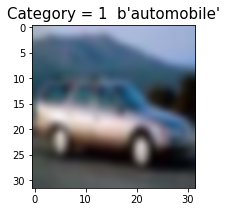

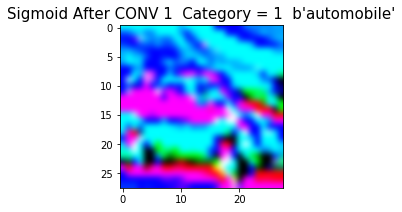

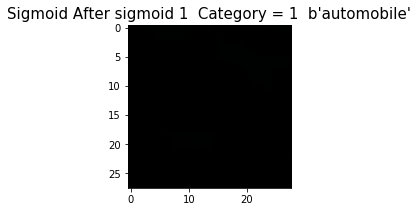

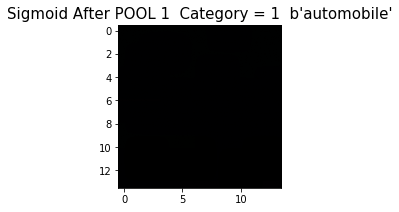

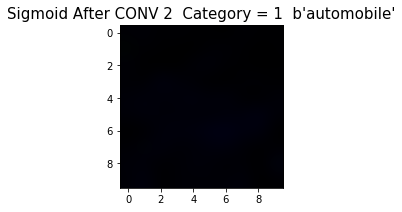

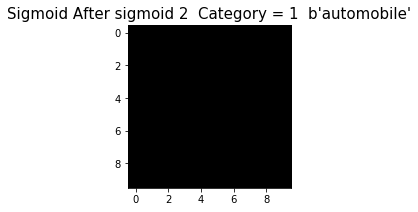

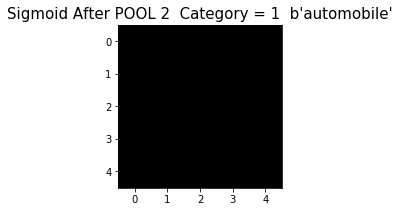

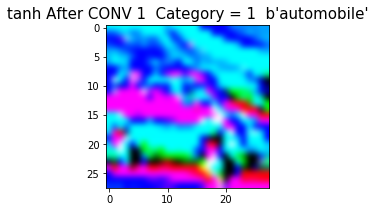

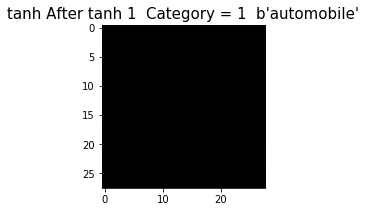

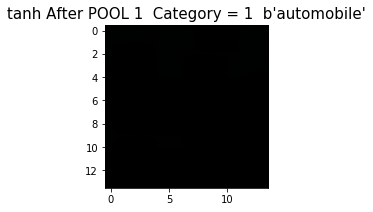

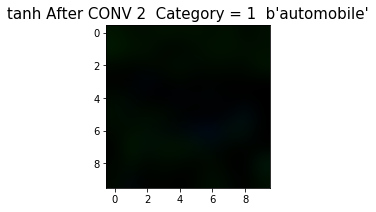

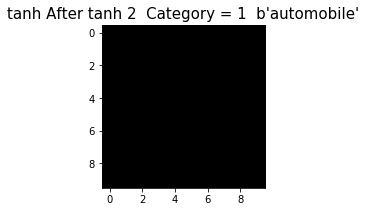

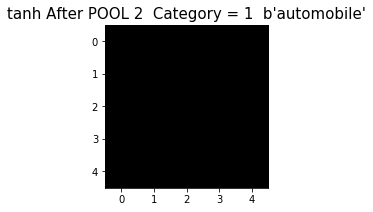

In [44]:
if __name__ == "__main__":
    main()

Observation 

The output generated is more like double and there is problem drawing image.So converted to float but the image is not properly visible